In [1]:
import os
import sys
import warnings
from datetime import datetime

import albumentations as A
import cv2
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pytorchcv.model_provider import get_model as ptcv_get_model
from torch import nn
from tqdm import tqdm_notebook as tqdm

sys.path.append('../scripts')
sys.path.append('../scripts/Synchronized-BatchNorm-PyTorch')

warnings.filterwarnings('ignore')


now = datetime.now()

now_date = now.strftime("%m%d")
now_time = now.strftime("%H%M")

In [2]:
from sync_batchnorm import convert_model

from melanoma_funcs import *
from melanoma_models import *

#### variable

In [3]:
# fold_number = 0
# batch_size = 50
# input_res  = 768
# use_external = True
# model_name = "efficientnet_b0c"
# gpus = [0,1]


In [7]:
np.random.seed(1)  
torch.manual_seed(1)  

import argparse
parser = argparse.ArgumentParser()
arg = parser.add_argument
arg('fold_number', type=int)
arg('batch_size', type=int)
arg('input_res', type=int)
arg('model_name', type=str)
arg('gpus', type=str)
arg('--now_date', type=str, default=None)
arg('--now_time', type=str, default=None)
args = parser.parse_args(args=['0','16', '512','efficientnet_b8c', '01'])#, "--now_date=0811", "--now_time=0812"])

print(args)

fold_number = args.fold_number
batch_size = args.batch_size
input_res = args.input_res
model_name = args.model_name
gpus = list(map(int, list(args.gpus)))
if args.now_date is not  None:
    now_date = args.now_date
if args.now_time is not None:
    now_time =args.now_time

Namespace(batch_size=16, fold_number=0, gpus='01', input_res=512, model_name='efficientnet_b8c', now_date=None, now_time=None)


In [8]:
print(now_date, now_time)

ROOT_PATH = '..'
DATA_PATH = f'{ROOT_PATH}/input/jpeg-melanoma-{input_res}x{input_res}/'
EXT_DATA_PATH = f'{ROOT_PATH}/input/jpeg-isic2019-{input_res}x{input_res}/'
TRAIN_ROOT_PATH = f'{DATA_PATH}/train'
EXT_TRAIN_ROOT_PATH = f'{EXT_DATA_PATH}/train'
TEST_ROOT_PATH = f'{DATA_PATH}/test'
CKPT_PATH = f'{ROOT_PATH}/checkpoints/fold{fold_number}_{input_res}x{input_res}/{now_date}/{now_time}/'
LOG_PATH = f'{ROOT_PATH}/logs/fold{fold_number}_{input_res}x{input_res}/{now_date}/{now_time}/'

FEATURES = ["sex", "age_approx", "width", "height", "anatom_site_general_challenge", "width/height", "width*height"]

0813 1702


# data load 

fold,0,1,2
ratio,0.08793,0.08749,0.086636


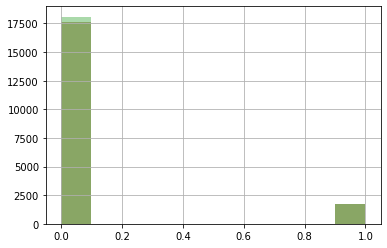

In [9]:
df_train = pd.read_csv(f'{DATA_PATH}/train.csv', index_col="image_name")
df_ext = pd.read_csv(f'{EXT_DATA_PATH}/train.csv', index_col="image_name")

df_train["data_path"] = TRAIN_ROOT_PATH
df_ext["data_path"] = EXT_TRAIN_ROOT_PATH

df_train = pd.concat([df_train, df_ext])
df_train["fold"] = df_train["tfrecord"] %3

df_train = df_train.drop("tfrecord", axis=1)

df_test = pd.read_csv(f'{DATA_PATH}/test.csv', index_col="image_name")
df_test["data_path"] = f"{DATA_PATH}/test"

_ = df_train.groupby('fold').target.hist(alpha=0.4)
df_train.groupby('fold').target.mean().to_frame('ratio').T


#### tableデータの特徴量エンジニアリング

In [10]:
df_concat = pd.concat([df_train, df_test])
df_concat["sex"] = (df_concat["sex"] =="male")
df_concat["age_approx"] = df_concat["age_approx"].fillna(df_concat["age_approx"].mean())
df_concat["anatom_site_general_challenge"] = df_concat["anatom_site_general_challenge"].fillna("unknown")
df_concat["anatom_site_general_challenge"] = df_concat["anatom_site_general_challenge"].map(dict(df_concat["anatom_site_general_challenge"].value_counts()))
df_concat["width/height"] = df_concat["width"] / df_concat["height"]
df_concat["width*height"] = df_concat["width"] * df_concat["height"]

df_concat[FEATURES] = (df_concat[FEATURES] - df_concat[FEATURES].mean()) / df_concat[FEATURES].std()

df_train = df_concat.loc[df_train.index]
df_test = df_concat.loc[df_test.index]#, df_test.columns]

df_val = df_train[(df_train['fold'] == fold_number) & (df_train["data_path"] ==TRAIN_ROOT_PATH)]
df_train = df_train[df_train['fold'] != fold_number]

In [11]:
ds_train = ImageDataset(
#     path=TRAIN_ROOT_PATH,
    df=df_train,
    labels=df_train.target.values,
    transforms=get_train_transforms(input_res),
)

ds_val = ImageDataset(
#     path=TRAIN_ROOT_PATH,
    # 外部データは除く
    df=df_val,
    labels=df_val.target.values,
    transforms=get_valid_transforms(input_res),
)

ds_test = ImageDataset(
#     path=TEST_ROOT_PATH,
    df=df_test,
    transforms=get_tta_transforms(input_res),
)

ds_train2 = ImageDataset(
#     path=TRAIN_ROOT_PATH,
    df=df_train,
    labels=df_train.target.values,
    transforms=get_train_transforms(input_res),
    feature_cols = FEATURES
)

ds_val2 = ImageDataset(
#     path=TRAIN_ROOT_PATH,
    # 外部データは除く
    df=df_val,
    labels=df_val.target.values,
    transforms=get_valid_transforms(input_res),
    feature_cols = FEATURES
)

ds_test2 = ImageDataset(
#     path=TEST_ROOT_PATH,
    df=df_test,
    transforms=get_tta_transforms(input_res),
    feature_cols = FEATURES
)

# del df_train
# len(ds_train), len(ds_val), len(ds_test)

In [ ]:
np.random.seed(1)  
torch.manual_seed(1)  
ckpt_path1 = f"{CKPT_PATH}/CNN"
log_path1 = f"{LOG_PATH}/CNN"
os.makedirs(log_path1, exist_ok=True)
os.makedirs(ckpt_path1, exist_ok=True)

tb_log = TensorBoardLogger(save_dir = f"{LOG_PATH}/CNN")

checkpoint_callback = ModelCheckpoint(
    filepath=ckpt_path1,
    save_top_k=4,
    verbose=True,
    monitor='val_auc',
    mode='max',
)

early_stop_callback = EarlyStopping(
   monitor='val_auc',
   min_delta=0.00,
   patience=6,
   verbose=True,
   mode='max'
)


# train

model = convert_model(MelanomaModel(model_name, ds_train, ds_val, ds_test, batch_size=batch_size))

trainer = pl.Trainer(max_epochs=100000, logger=tb_log, checkpoint_callback=checkpoint_callback,
                     early_stop_callback=early_stop_callback, gpus=gpus, distributed_backend='dp', num_sanity_val_steps=0)

trainer.fit(model)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0,1]

  | Name | Type         | Params
--------------------------------------
0 | net  | EfficientNet | 84 M  
1 | fc   | Linear       | 2 K   


In [10]:
## inference
best_epoch = max(model.val_auc, key=model.val_auc.get)
oof_preds = pd.DataFrame(index=df_val.index).reset_index()
oof_preds["target"] = model.oof_preds[best_epoch].squeeze()
oof_preds.to_csv(f"{CKPT_PATH}/CNN/oof_preds.csv", index=False)

model = MelanomaModel.load_from_checkpoint(checkpoint_callback.best_model_path, model_name=model_name,
                                  ds_train=ds_train, ds_val=ds_val, ds_test=ds_test, batch_size=batch_size)

##TTA
preds_list = list()

for i in tqdm(range(25)):
    trainer.test(model)
    preds_list.append(model.test_predicts)

preds_arr = np.array(preds_list).squeeze()
new_preds = preds_arr.mean(axis=0)

model.test_predicts = new_preds


# submission

submission = pd.read_csv(f"{DATA_PATH}/sample_submission.csv")
submission["target"] = model.test_predicts.squeeze()
submission.to_csv(f"{ROOT_PATH}/output/submissionCNN.csv", index=False)
submission.to_csv(f"{CKPT_PATH}/CNN/submission.csv", index=False)

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------




In [ ]:
ckpt_path2 = f"{CKPT_PATH}/MLP"
log_path2 = f"{LOG_PATH}/MLP"
os.makedirs(log_path2, exist_ok=True)
os.makedirs(ckpt_path2, exist_ok=True)

tb_log2 = TensorBoardLogger(save_dir = f"{LOG_PATH}/MLP")

checkpoint_callback2 = ModelCheckpoint(
    filepath=ckpt_path2,
    save_top_k=4,
    verbose=True,
    monitor='val_auc',
    mode='max',
)

early_stop_callback2 = EarlyStopping(
   monitor='val_auc',
   min_delta=0.00,
   patience=6,
   verbose=True,
   mode='max'
)


concat_model = convert_model(ConcatModel(model, ds_train2, ds_val2, ds_test2, batch_size=batch_size, n_features=len(FEATURES)))
trainer2 = pl.Trainer(max_epochs=100000, logger=tb_log2, checkpoint_callback=checkpoint_callback2,
                     early_stop_callback=early_stop_callback2, gpus=gpus, distributed_backend='dp', num_sanity_val_steps=0)


trainer2.fit(concat_model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0,1]

   | Name        | Type                    | Params
---------------------------------------------------------
0  | image_model | MelanomaModel           | 10 M  
1  | layer1_1    | Linear                  | 512   
2  | bn1_1       | SynchronizedBatchNorm1d | 128   
3  | layer1_2    | Linear                  | 2 K   
4  | layer2_1    | Linear                  | 1 M   
5  | bn2_1       | SynchronizedBatchNorm1d | 2 K   
6  | layer2_2    | Linear                  | 524 K 
7  | bn2_2       | SynchronizedBatchNorm1d | 1 K   
8  | layer2_3    | Linear                  | 131 K 
9  | bn2_3       | SynchronizedBatchNorm1d | 512   
10 | fc          | Linear                  | 257   



Epoch 00000: val_auc reached 0.83941 (best 0.83941), saving model to ../checkpoints/fold0_768x768/0813/0918//MLP/epoch=0.ckpt as top 4



Epoch 00001: val_auc reached 0.91544 (best 0.91544), saving model to ../checkpoints/fold0_768x768/0813/0918//MLP/epoch=1.ckpt as top 4



Epoch 00002: val_auc reached 0.90327 (best 0.91544), saving model to ../checkpoints/fold0_768x768/0813/0918//MLP/epoch=2.ckpt as top 4



Epoch 00003: val_auc reached 0.91941 (best 0.91941), saving model to ../checkpoints/fold0_768x768/0813/0918//MLP/epoch=3.ckpt as top 4



Epoch 00004: val_auc reached 0.91882 (best 0.91941), saving model to ../checkpoints/fold0_768x768/0813/0918//MLP/epoch=4.ckpt as top 4



Epoch 00005: val_auc  was not in top 4



Epoch 00006: val_auc reached 0.92085 (best 0.92085), saving model to ../checkpoints/fold0_768x768/0813/0918//MLP/epoch=6.ckpt as top 4



Epoch 00007: val_auc  was not in top 4



Epoch 00008: val_auc  was not in top 4



Epoch 00009: val_auc reached 0.92231 (best 0.92231), saving model to ../checkpoints/fold0_768x768/0813/0918//MLP/epoch=9.ckpt as top 4



Epoch 00010: val_auc  was not in top 4



Epoch 00011: val_auc reached 0.92514 (best 0.92514), saving model to ../checkpoints/fold0_768x768/0813/0918//MLP/epoch=11.ckpt as top 4



Epoch 00012: val_auc  was not in top 4



Epoch 00013: val_auc  was not in top 4



Epoch 00014: val_auc  was not in top 4



Epoch 00015: val_auc reached 0.93080 (best 0.93080), saving model to ../checkpoints/fold0_768x768/0813/0918//MLP/epoch=15.ckpt as top 4



Epoch 00016: val_auc reached 0.92901 (best 0.93080), saving model to ../checkpoints/fold0_768x768/0813/0918//MLP/epoch=16.ckpt as top 4



Epoch 00017: val_auc  was not in top 4



Epoch 00018: val_auc  was not in top 4



Epoch 00019: val_auc  was not in top 4



Epoch 00020: val_auc reached 0.92439 (best 0.93080), saving model to ../checkpoints/fold0_768x768/0813/0918//MLP/epoch=20.ckpt as top 4



Epoch 00021: val_auc reached 0.92577 (best 0.93080), saving model to ../checkpoints/fold0_768x768/0813/0918//MLP/epoch=21.ckpt as top 4
Epoch 00022: early stopping triggered.


1

In [ ]:
## inference
best_epoch = max(concat_model.val_auc, key=concat_model.val_auc.get)
oof_preds = pd.DataFrame(index=df_val.index).reset_index()
oof_preds["target"] = concat_model.oof_preds[best_epoch].squeeze()
oof_preds.to_csv(f"{CKPT_PATH}/MLP/oof_preds.csv", index=False)

concat_model = ConcatModel.load_from_checkpoint(checkpoint_callback2.best_model_path, image_model=model,
                                  ds_train=ds_train2, ds_val=ds_val2, ds_test=ds_test2, batch_size=batch_size, n_features=len(FEATURES))
##TTA
preds_list = list()

for i in tqdm(range(25)):
    trainer2.test(concat_model)
    preds_list.append(concat_model.test_predicts)

preds_arr = np.array(preds_list).squeeze()
new_preds = preds_arr.mean(axis=0)

concat_model.test_predicts = new_preds


# submission

submission = pd.read_csv(f"{DATA_PATH}/sample_submission.csv")
submission["target"] = concat_model.test_predicts.squeeze()
submission.to_csv(f"{ROOT_PATH}/output/submissionMLP.csv", index=False)
submission.to_csv(f"{CKPT_PATH}/MLP/submission.csv", index=False)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------


